# Deep Learning in Medicine
### BMSC-GA 4493, BMIN-GA 3007 
### Homework 4



**Note:** If you need to write mathematical terms, you can type your answeres in a Markdown Cell via LaTex 

See: <a href="https://stackoverflow.com/questions/13208286/how-to-write-latex-in-ipython-notebook">here</a> if you have issues. To see basic LaTex notation see: <a href="https://en.wikibooks.org/wiki/LaTeX/Mathematics"> here </a>.

**Submission instruction**: Upload and Submit your final jupyter notebook with necessary files in <a href='http://newclasses.nyu.edu'>newclasses.nyu.edu</a>. If you use code or script from web, please give a link to the code in your answers.

**Submission deadline:** Saturday May 12th 2018 (5:00 PM)

# Question 1: Literature Review: DeepPatient (Total 25 points + 10 points for Bonus question)

Read this paper:

Riccardo Miotto, Li Li, Brian A. Kidd & Joel T. Dudley, "Deep Patient: An Unsupervised Representation to Predict the Future of Patients from the Electronic Health Records" Scientific Reports, 2016 https://www.nature.com/articles/srep26094.pdf

We are interested in understanding the task, the methods that is proposed in this publication, technical aspects of the implementation, and possible future work. After you read the full article answer the following questions. Describe you answers in your own words.  

### 1.1) (5 points) 
What type of learning algorithm is used (supervised, semi-supervised or unsupervised)? What is the reason for selecting this type of learning algorithm?

The learning algithm is unsupervised. The reason this was chosen is that generally an expert is required to select features and patterns are identified within the data. This approach does not allow the algorithm to identify new patterns or features within the data. An alternative approach is data driven feature selection which results in sparse vectors which are not suitable for the approach taken by the authors.

### 1.2) (5 points)
What type of neural network architecture is used in the paper? What is the reason for selecting this type of network?

A multi-layer neural network in a deep learning architecture which consists of a stack of denoising autoencoders

By combining multiple layers the model is able to achieve higher levels of abstraction and use this higher level of abstraction to identify patterns within the data.

### 1.3) (5 points) 
What is the loss function? Whay kind of approaches are used to improve model generalization?

A reconstruction cross-entropy loss function was used.
Masking noise algorithm which randomly sets some input features to zero. This similates a missed input within an EHR.

### 1.4) (5 points) 
How many hidden layers and units does DeepPatient has? What type of activation function is used?

Three layers of auto encoders using Sigmoid activation functions.

### 1.5) (5 points) 
What are the evaluation metrics used for model comparison? Explain why those metrics were chosen?

AUC-ROC, accuracy and F score. These metrics cover a wide range of methods of evaluating a model. AUROC compares the true positive prediction rate to the false positive prediction rate. Accuracy reflects the proprotion of true results and the f score is the models accuracy in terms of precision and recall.

### 1.6) (Bonus: maximum 10 points) 
How did the authors decide on using specific number of hidden layers in the article? What other architectures would you try?

The authors compared the evaluation metrics for models of varying depth and observed that after 3 layers there was little to no improvement in the performance of the model.

I would try to incorperate a recursive nerual network into the model.

# Question 2: Transfer learning for disease classification (Total 75 points + 20 points in bonus question)

In this part of the howework, we will revisit the disease classification task we worked on HW2. As opposed to developing our own CNN network as we did on HW2, in this HW we are interested in using transfer learning for the disease classification task.  we will use ResNet50 model to achieve this goal. Here is the link for the ResNet paper: https://arxiv.org/pdf/1512.03385.pdf You will use ResNet50 model as a fixed feature extractor in this question. 

As a reminder: we focused on classifiying the lung disease using chest x-ray dataset provided by NIH (https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community). Please go over the following paper for the details of the dataset: https://arxiv.org/pdf/1705.02315.pdf 

You need to use HPC for training part of this question, as your computer's CPU will not be fast enough to compute learning iterations. In case you use HPC, please have your code/scripts uploaded under the questions and provide the required plots and tables there as well. Data is available in HPC under /beegfs/ga4493/data/HW2 folder. We are interested in classifying infiltration, pneumothorax, cardiomegaly and *not*(infiltration OR pneumothorax OR cardiomegaly) cases. By saying so we have 4 classes that we want to identify by modelling a deep CNN.

Due to time limitations you do not need to your models using the whole dataset, we will use HW2_RandomtrainSet.csv, HW2_testSet.csv and HW2_RandomvalidationSet.csv provided under /beegfs/ga4493/data/HW2 folder for defining train, test and validation set samples that are generated in HW2 Q3.1.
In these .csv files 4 classes were defined as :
- 1 infiltration
- 2 pneumothorax
- 3 cardiomegaly
- 0 for all other diseases (doesnt have infiltration OR pneumothorax OR cardiomegaly) or NoFinding

## 2.1) Define dataloaders for train, test and validations sets
We used Dataset class defined in HW2. Here, we have a copy of it. You need to make necessary changes to make the dataset class is capable of feeding the X-ray dataset into resnet model for transfer learning. Remember X-ray data has grayscale images of 1024x1024 pixels and resnet50 model requires RGB images of size 224x224. Add necessary code to the specified locations: 

### 2.1.a) (10 points) 
Define data transforms required for train and validation/test data

In [3]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color, transform
from skimage.transform import resize

# Torchvision transforms are buggy in the version of pytorch I am using
# for this reason I am using skimage to resize
train_transform = True

validation_transform = True

class ChestXrayDataset(Dataset):
    """Chest X-ray dataset from https://nihcc.app.box.com/v/ChestXray-NIHCC."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.data_frame.iloc[idx, 0])
        
        #some cases io.imread brings more channels than 1 due to bitsize issues
        # for this reason load the image as gray
        image = io.imread(img_name, as_grey=True)

        image_class = self.data_frame.iloc[idx, -1]
        
        # normalize the image - I think that resnet does this
#         image = (image - image.mean()) / image.std()
        
        # this will resize the grayscale image
        if self.transform:
            image = transform.resize(image, (224, 224), mode='reflect')
            
        # replicate the image into 3 RGB channels
        image=np.repeat(image[None,...],3,axis=0)
            
        sample = {'x': image, 'y': image_class}

        return sample


### 2.1.b) (5 points)
Define train, validation and test dataloaders loaders using the dataset class defined in Q.3.1.a and .csv files: HW2_RandomtrainSet.csv, HW2_testSet.csv and HW2_RandomvalidationSet.csv

In [4]:
## Defining the data loaders with emprical batch size 
BATCH_SIZE = 16
## data loaders
chestXray_TrainData = ChestXrayDataset('HW2_randomTrainSet.csv', '/beegfs/ga4493/data/HW2/images', train_transform)
train_loader = DataLoader(chestXray_TrainData, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)


chestXray_ValidationData = ChestXrayDataset('HW2_randomValidationSet.csv', '/beegfs/ga4493/data/HW2/images', validation_transform)
validation_loader = DataLoader(chestXray_ValidationData, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

chestXray_TestData = ChestXrayDataset('HW2_testSet.csv', '/beegfs/ga4493/data/HW2/images', True)
test_loader = DataLoader(chestXray_TestData, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

dataset_sizes = {'train': len(chestXray_TrainData), 'val': len(chestXray_ValidationData)}
print(dataset_sizes)

{'train': 256, 'val': 64}


### Helper functions --> You dont need to add/remove anything here. Functions implemented on HW2 will be used here. if you want, you can use your own functions as well

In [12]:
import time
import copy
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

use_gpu = torch.cuda.is_available()

def train_model(model, criterion, optimizer, num_epochs=25, trainVal=['train','val'],verbose=True):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss2plot = np.zeros([2,num_epochs])
    acc2plot  = np.zeros([2,num_epochs])

    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in trainVal:
            if phase == 'train':
                imageLoader = train_loader
            else:
                imageLoader = validation_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample_batched in imageLoader:
                # get the inputs
                #print(sample_batched)
                inputs = sample_batched['x']
                labels = sample_batched['y']

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs).type(torch.FloatTensor).cuda()
                    labels = Variable(labels).type(torch.LongTensor).cuda()
                else:
                    inputs, labels = Variable(inputs).type(torch.FloatTensor), Variable(labels).type(torch.LongTensor)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
#                 print(labels.data,preds,preds == labels.data,outputs.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if verbose:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                loss2plot[0,epoch] = epoch_loss
                acc2plot[0,epoch] = epoch_acc
            else:
                loss2plot[1,epoch] = epoch_loss
                acc2plot[1,epoch] = epoch_acc
                    

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if verbose:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    for phase in trainVal:
        if phase == 'train':
            idx=0
        else:
            idx=1
            
        fig = plt.figure()
        
    
        a = fig.add_subplot(2,2,2*idx+1)
        plt.plot(loss2plot[idx,:])
        plt.title('Loss per epoch for ' + phase)
        #plt.suptitle('Curves for ' + phase)

        a = fig.add_subplot(2,2,2*idx+2)
        plt.plot(acc2plot[idx,:])
        plt.title('Accuracy per epoch for ' + phase)
        plt.show()

        #plt.plot(loss2plot[idx,:]);plt.title('Loss per epoch for ' + phase); plt.show()
        #plt.plot(acc2plot[idx,:]);plt.title('Accuracy per epoch for ' + phase); plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

# This is the place we predict the disease from a model trained, output for this function is 
#the target values and probabilty of each image having a disease 
import torch.nn.functional as F
def inference(model_ft,loader):
    use_gpu = 1
    model_ft.eval()
    whole_output =[]
    whole_target = []

    for valData in loader:
        data = valData['x']
        target = valData['y']
        if use_gpu:
            data = Variable(data,volatile=True).type(torch.FloatTensor).cuda()
            target = Variable(target,volatile=True).type(torch.LongTensor).cuda()
        else:
            data, target = Variable(data,volatile=True).type(torch.FloatTensor), Variable(target,volatile=True).type(torch.LongTensor)

        output = F.softmax(model_ft(data))
        whole_output.append( output.cpu().data.numpy())
        whole_target.append( valData['y'].numpy())

    whole_output = np.concatenate(whole_output)
    whole_target = np.concatenate(whole_target)

    y_score = whole_output
    y_target = label_binarize(whole_target, classes=[0, 1, 2, 3])
    
    return y_score, y_target

# this function AUC of ROC for each disease seperately and also macro and micro averages,
# we will use macro average to compare different models we will train. 
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def get_AUC(y_score, y_target,plotROC=False):
    n_classes = y_score.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_target[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_target.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    if plotROC:
        lw = 2
        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()

    return roc_auc

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

## 2.2) Loading the pre-trained CNN model, training the model and analyzing results (TL as a feature extractor) 

### 2.2.a) (6 points)
Since now we can import images using dataloaders, next step is to load the pretrained resnet50 network from torchvision.models and prepare it for transfer learning for using resnet model as a feature extractor (see slide #12 for Lecture 12). Write the code for designing resnet50 architecture and loading the weights from ImageNet trained network. 


In [84]:
resnet50 = torchvision.models.resnet50(pretrained=True)
# from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
for param in resnet50.parameters():
    param.requires_grad = False
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 4)
resnet50.cuda()

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): Bott

### 2.2.b) (4 points)
Define the loss and the optimizer you want to use 

In [85]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)

### 2.2.c) (4 points)
Train the model for 100 epochs and save the weights of the best model using the validation loss. Plot train and validation loss curves

Training complete in 8m 1s
Best val Acc: 0.437500


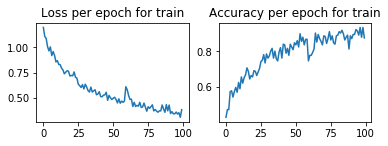

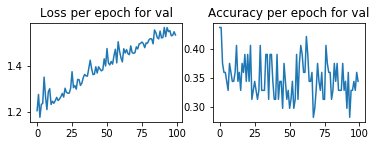

In [86]:
model_FE = train_model(resnet50, criterion, optimizer,
                       num_epochs=100, trainVal=['train','val'],verbose=False) 

### 2.2.d) (4 points)
Plot ROC curve of the best model using the dataloader of the test data

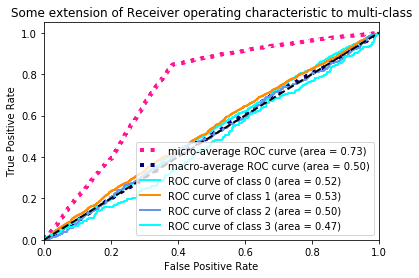

macro AUC for the model trained on full data is :  0.503595601868


In [89]:
y_s, y_t=inference(model_FE,test_loader)
r_AUC_wholeSet = get_AUC(y_s, y_t,True)
print('macro AUC for the model trained on full data is : ', r_AUC_wholeSet['macro'])

### 2.2.e) (4 points)
Compute the confusion matrix

Confusion matrix, without normalization
[[1684    2    0    0]
 [1932    7    0    0]
 [ 438    0    0    0]
 [ 217    1    0    0]]


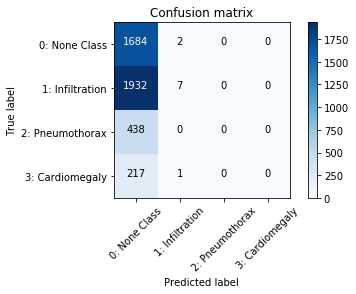

In [90]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t.dot([0,1,2,3]), np.argmax(y_s,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['0: None Class','1: Infiltration','2: Pneumothorax','3: Cardiomegaly']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

## 2.3) Loading the pre-trained CNN model, training the model and analyzing results (TL with fine-tuning) 

### 2.3.a) (6 points)
Perform a transfer learning using resnet50 model as a fine-tuning base model (see slide #13 for Lecture 12).
Write the code for designing resnet50 architecture and loading the weights from ImageNet trained network.                                                                       

In [91]:
resnet50 = torchvision.models.resnet50(pretrained=True)
# from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 4)
resnet50.cuda()

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): Bott

### 2.3.b) (4 points)
Define the loss and the optimizer you want to use

In [94]:
from torch.optim import lr_scheduler
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### 2.3.c) (4 points)
Train the model for 100 epochs and save the weights of the best model using the validation loss. Plot train and validation loss curves

Training complete in 8m 54s
Best val Acc: 0.453125


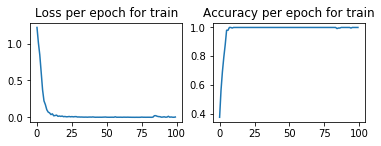

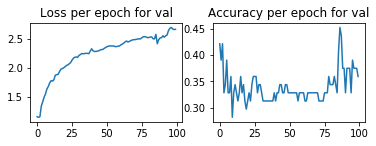

In [95]:
model_FT = train_model(resnet50, criterion, optimizer,
                       num_epochs=100, trainVal=['train','val'],verbose=False) 

### 2.3.d) (4 points)
Plot ROC Curve and confusion matrix

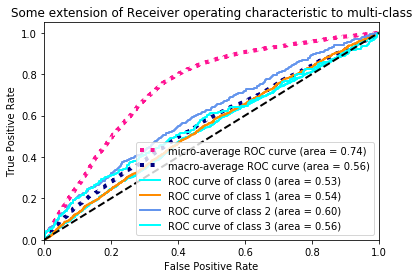

macro AUC for the model trained on full data is :  0.561220798736
Confusion matrix, without normalization
[[ 918  765    3    0]
 [ 935 1002    2    0]
 [ 251  182    5    0]
 [  97  121    0    0]]


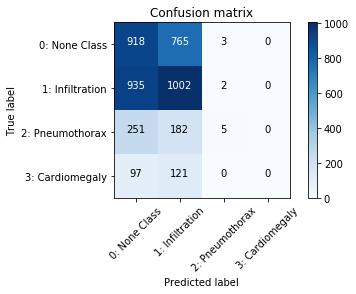

In [96]:
y_s, y_t=inference(model_FT,test_loader)
r_AUC_wholeSet = get_AUC(y_s, y_t,True)
print('macro AUC for the model trained on full data is : ', r_AUC_wholeSet['macro'])

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t.dot([0,1,2,3]), np.argmax(y_s,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['0: None Class','1: Infiltration','2: Pneumothorax','3: Cardiomegaly']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

### 2.4) (10 points)
Descibe your findings using two different TL approaches that you implemented in Q2.2. and Q2.3. for example what are the differences in terms of speed, accuracy, and so on. Was TL successfull classifying lung diseases?

Fine tuning (FT) was almost a minute slower than feature extraction (FE) (8m:1s vs 8m:54s). As I only ran the training once for each model there could be some variation in the times. You would expect the fine tuning model to be slightly slower as the weights for the entire model are being updated versus the feature extraction model in which only a single dense layer is being updated.

The best accuracy was better in the FT model (0.453125 vs 0.437500). The FT was able to overfit to the training data very quickly while the FE model did not.

The FE model predicted the None class for almost all of the test samples while the FT model predicted some Infiltration as well as None Class and had a betro macro AUC. The FE did not predict any pneumothorax while the FT model did. Neither model predicted any Cardiomegaly.

While FT at least created a model that predicted more than one class, neither model performed well at classifying lung disease.

### 2.5) (10 points) 
In the view of your findings, describe transfer learning approaches we used in this HW in terms of data size and emprical observation domain specifics (Hint: Checkslide # 16 on Lecture #12). What can you do better to improve transfer learning? Propose changes to the current TL strategies. 

The data size of the new data set is small and the domain is very different from the domain used to train the model.

Guidelines indicate that when using a small dataset it is better to only train the classification layer of the model.

As the dataset is very different it would be better to only use lower levels within the existing model as the higher levels will be specialized at identifying specific features found in the dataset used to train the model.

The changes I propose are the only use the first few sequential layers within resnet and freeze the weights of these layers. A final classification layer will be trained to make predictions.

### 2.6) Bonus Question (maximum 20 points) 
Implement the changes you proposed in Q2.5 and analyze your results

In [26]:
from torch.optim import lr_scheduler
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        resnet50 = torchvision.models.resnet50(pretrained=True)
        for param in resnet50.parameters():
            param.requires_grad = False
        num_ftrs = resnet50.fc.in_features
        front = list(resnet50.children())[:5]
        back = list(resnet50.children())[-2:]
        self.model = nn.Sequential(*(front + [back[0]]))
        self.fc = nn.Linear(16384, 4)
        
    def forward(self, image):
        x = self.model(image)
        x = x.view(-1, 16384)
#         print(x.size())
        x = self.fc(x)
        return x

resnet50 = MyModel()
print(resnet50)
resnet50.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)

MyModel (
  (model): Sequential (
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (4): Sequential (
      (0): Bottleneck (
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (downsample): Sequential (
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

In [27]:
for sample_batched in train_loader:
    # get the inputs
    #print(sample_batched)
    inputs = sample_batched['x']
    labels = sample_batched['y']

    # wrap them in Variable
    if use_gpu:
        inputs = Variable(inputs).type(torch.FloatTensor).cuda()
        labels = Variable(labels).type(torch.LongTensor).cuda()
    else:
        inputs, labels = Variable(inputs).type(torch.FloatTensor), Variable(labels).type(torch.LongTensor)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    outputs = resnet50(inputs)
    print(outputs.size())
#     _, preds = torch.max(outputs.data, 1)
#     loss = criterion(outputs, labels)
    break

torch.Size([16, 4])


Training complete in 7m 24s
Best val Acc: 0.484375


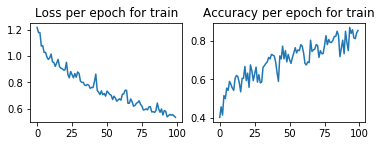

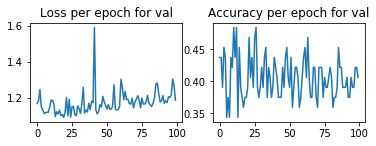

In [28]:
model_M = train_model(resnet50, criterion, optimizer,
                       num_epochs=100, trainVal=['train','val'],verbose=False) 

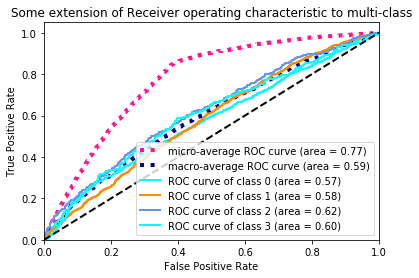

macro AUC for the model trained on full data is :  0.593756582391
Confusion matrix, without normalization
[[ 240 1446    0    0]
 [ 121 1818    0    0]
 [  31  407    0    0]
 [  23  195    0    0]]


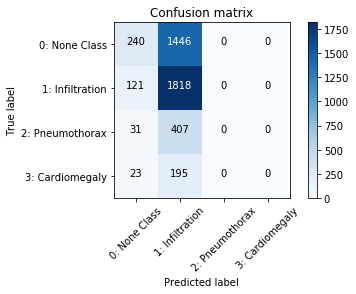

In [29]:
y_s, y_t=inference(model_M,test_loader)
r_AUC_wholeSet = get_AUC(y_s, y_t,True)
print('macro AUC for the model trained on full data is : ', r_AUC_wholeSet['macro'])

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t.dot([0,1,2,3]), np.argmax(y_s,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['0: None Class','1: Infiltration','2: Pneumothorax','3: Cardiomegaly']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

In [30]:
from torch.optim import lr_scheduler
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        resnet50 = torchvision.models.resnet50(pretrained=True)
        for param in resnet50.parameters():
            param.requires_grad = False
        num_ftrs = resnet50.fc.in_features
        front = list(resnet50.children())[:6]
        back = list(resnet50.children())[-2:]
        self.model = nn.Sequential(*(front + [back[0]]))
        self.fc = nn.Linear(8192, 4)
        
    def forward(self, image):
        x = self.model(image)
        x = x.view(-1, 8192)
#         print(x.size())
        x = self.fc(x)
        return x

resnet50 = MyModel()

resnet50.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)

In [31]:
for sample_batched in train_loader:
    # get the inputs
    #print(sample_batched)
    inputs = sample_batched['x']
    labels = sample_batched['y']

    # wrap them in Variable
    if use_gpu:
        inputs = Variable(inputs).type(torch.FloatTensor).cuda()
        labels = Variable(labels).type(torch.LongTensor).cuda()
    else:
        inputs, labels = Variable(inputs).type(torch.FloatTensor), Variable(labels).type(torch.LongTensor)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    outputs = resnet50(inputs)
    print(outputs.size())
#     _, preds = torch.max(outputs.data, 1)
#     loss = criterion(outputs, labels)
    break

torch.Size([16, 4])


Training complete in 7m 35s
Best val Acc: 0.468750


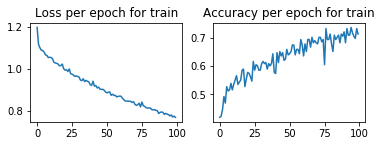

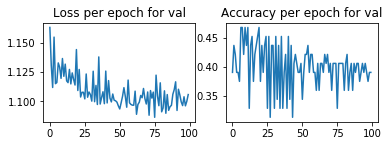

In [32]:
model_M = train_model(resnet50, criterion, optimizer,
                       num_epochs=100, trainVal=['train','val'],verbose=False) 

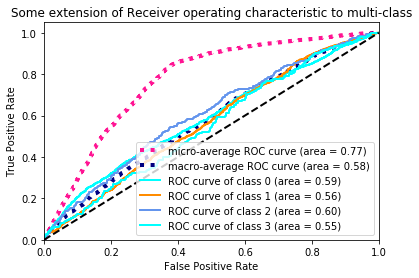

macro AUC for the model trained on full data is :  0.576052119851
Confusion matrix, without normalization
[[ 333 1353    0    0]
 [ 169 1770    0    0]
 [  43  395    0    0]
 [  26  192    0    0]]


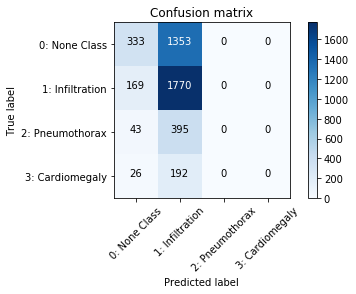

In [33]:
y_s, y_t=inference(model_M,test_loader)
r_AUC_wholeSet = get_AUC(y_s, y_t,True)
print('macro AUC for the model trained on full data is : ', r_AUC_wholeSet['macro'])

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t.dot([0,1,2,3]), np.argmax(y_s,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['0: None Class','1: Infiltration','2: Pneumothorax','3: Cardiomegaly']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

In [34]:
from torch.optim import lr_scheduler
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        resnet50 = torchvision.models.resnet50(pretrained=True)
        for param in resnet50.parameters():
            param.requires_grad = False
        num_ftrs = resnet50.fc.in_features
        front = list(resnet50.children())[:7]
        back = list(resnet50.children())[-2:]
        self.model = nn.Sequential(*(front + [back[0]]))
        self.fc = nn.Linear(4096, 4)
        
    def forward(self, image):
        x = self.model(image)
        x = x.view(-1, 4096)
#         print(x.size())
        x = self.fc(x)
        return x

resnet50 = MyModel()
print(resnet50)
resnet50.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)

MyModel (
  (model): Sequential (
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (4): Sequential (
      (0): Bottleneck (
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (downsample): Sequential (
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

In [35]:
for sample_batched in train_loader:
    # get the inputs
    #print(sample_batched)
    inputs = sample_batched['x']
    labels = sample_batched['y']

    # wrap them in Variable
    if use_gpu:
        inputs = Variable(inputs).type(torch.FloatTensor).cuda()
        labels = Variable(labels).type(torch.LongTensor).cuda()
    else:
        inputs, labels = Variable(inputs).type(torch.FloatTensor), Variable(labels).type(torch.LongTensor)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    outputs = resnet50(inputs)
    print(outputs.size())
#     _, preds = torch.max(outputs.data, 1)
#     loss = criterion(outputs, labels)
    break

torch.Size([16, 4])


Training complete in 7m 39s
Best val Acc: 0.468750


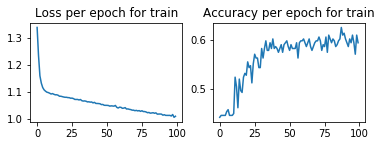

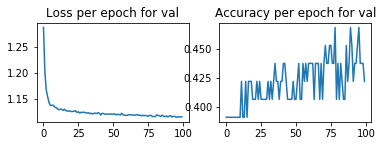

In [36]:
model_M = train_model(resnet50, criterion, optimizer,
                       num_epochs=100, trainVal=['train','val'],verbose=False) 

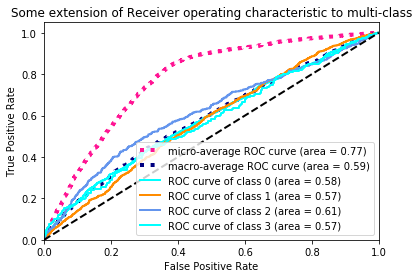

macro AUC for the model trained on full data is :  0.585491703728
Confusion matrix, without normalization
[[ 635 1051    0    0]
 [ 500 1439    0    0]
 [ 124  314    0    0]
 [  63  155    0    0]]


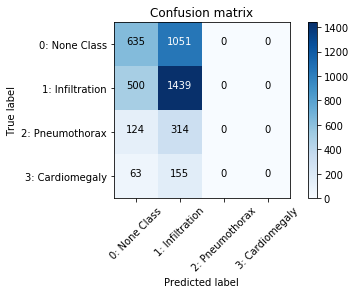

In [37]:
y_s, y_t=inference(model_M,test_loader)
r_AUC_wholeSet = get_AUC(y_s, y_t,True)
print('macro AUC for the model trained on full data is : ', r_AUC_wholeSet['macro'])

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t.dot([0,1,2,3]), np.argmax(y_s,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['0: None Class','1: Infiltration','2: Pneumothorax','3: Cardiomegaly']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

RESNET 1 sequential Layer
+ Train Time: 7m:24s
+ parameters in final layer: 65,540
+ Best validation Accuracy: 48%
+ Macro AUC: 59%

```
[[ 240 1446    0    0]
 [ 121 1818    0    0]
 [  31  407    0    0]
 [  23  195    0    0]]
```

Comments: Only predicted infiltration or no class, far more infiltration.

RESNET 2 sequential Layer
+ Train Time: 7m:35s
+ parameters in final layer: 32,772
+ Best validation Accuracy: 47%
+ Macro AUC: 58%

```
[[ 333 1353    0    0]
 [ 169 1770    0    0]
 [  43  395    0    0]
 [  26  192    0    0]]
```

Comments: Predicted most as infiltration and some as No class, pneumothorax and cardiomegaly did not get any predictions.
Macro AUC was 2% better than FT.

RESNET 3 sequential Layer
+ Train Time: 7m:39s
+ parameters in final layer: 16,388
+ Best validation Accuracy: 47%%
+ Macro AUC: 59% 

```
[[ 635 1051    0    0]
 [ 500 1439    0    0]
 [ 124  314    0    0]
 [  63  155    0    0]]
```

Comments: Once again the number of no class predicted went up. The model still does not predict pneumothorax or cardiomegaly. 

Findings:

Given fewer layers the model will be less capable of abstraction, the reason that infiltration is identified more frequently by a architecture with fewer sequential layers could be due to infiltration being the most common class in the data set. As you increase the number of sequential layers in resnet the model predicts more images as being type None. These changes resulted in macro AUC scores that were far better than FE using the entire mode and slightly better scores than FT. While the scores improved this is still not a very effective architecture for this problem. 